# NEURALS AI - NLP DATALAB

## Aplicando técnicas de NLP em aprendizado supervisionado

![NLP](./resources/image/nlp.jpg)

## Summary
1. Importando a base de dados
2. Análise Exploratória
3. Pré-processamento
4. Comparando acurácias de cada filtro
5. Analisando Modelo

## 1. Importando a base de dados

In [1]:
"""
-*- coding: utf-8 -*-
@author: Lucas Moutinho, Tiago Cabral
@colaborators: Thiago Russo, Emmanuel Perotto, Thiago Pinho
"""

import pandas as pd
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import WordPunctTokenizer
import plotly.express as px
from plots import plot_term_scatter, plot_categories_distribution,\
    plot_wordcloud
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GroupKFold, KFold, StratifiedShuffleSplit, StratifiedKFold, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, classification_report,\
    plot_confusion_matrix
import matplotlib.pyplot as plt

VECTOR_MODEL_NAME = "pt_core_news_sm"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)

In /home/moutinho/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/moutinho/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/moutinho/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/moutinho/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/moutinho/.local/lib/python3.6/site-packages/matplotlib/

In [2]:
dataset_path = "./resources/data/Feeds_Label.csv"
data = pd.read_csv(dataset_path)

In [3]:
data.head()

id  pick_count                                            content  \
0  11           0  A forte ligação dos cães com o ser humano desp...   
1  12           0  Os chamados muros da gentileza estão promovend...   
2   9           0  Alguns de nós sabem a sorte que é ter um irmão...   
3   6           0               Temos muito o que aprender com elas.   
4   1           0  Esqueça o que te disseram sobre a zona de conf...   

                                               title    Label_Train  
0  Há mais de 10 anos, dupla de cães 🐶 acompanha ...        Animais  
1  Muros da gentileza ajudam desabrigados e famíl...  Solidariedade  
2  20 fotos maravilhosas mostrando a alegria de t...        Familia  
3  13 razões pelas quais crianças são bem mais es...       Criancas  
4  Ex-executiva fala sobre vida sem propósito - I...      Proposito

## 2. análise exploratória

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888 entries, 0 to 887
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           888 non-null    int64 
 1   pick_count   888 non-null    int64 
 2   content      886 non-null    object
 3   title        888 non-null    object
 4   Label_Train  888 non-null    object
dtypes: int64(2), object(3)
memory usage: 34.8+ KB


In [5]:
data_plot = plot_categories_distribution(data,
                                                 'Label_Train', 
                                                 'id', 
                                                 'Initial distribution of Categories in the Ribon News dataset')

In [6]:
print('Column TITLE mean length is ', int(data['title'].str.len().mean()),
      ' and standard deviation was ', int(data['title'].str.len().std())) 
print('Column CONTENT mean length is ', int(data['content'].str.len().mean()),
      ' and standard deviation was ', int(data['content'].str.len().std()))

Column TITLE mean length is  70  and standard deviation was  16
Column CONTENT mean length is  551  and standard deviation was  289


## 3. Pré-processamento

### 3.1 Preparação de dados

In [7]:
data = data.dropna()

data = pd.concat([
    data[['title', 'Label_Train']].rename(columns={'title':"Title_and_Content"}), 
    data[['content', 'Label_Train']].rename(columns={'content':"Title_and_Content"})
])

data['Title_and_Content'] = data['Title_and_Content'].str.lower()
data['Label_Train'] = data['Label_Train'].str.lower()

In [8]:
data.head()

Title_and_Content    Label_Train
0  há mais de 10 anos, dupla de cães 🐶 acompanha ...        animais
1  muros da gentileza ajudam desabrigados e famíl...  solidariedade
2  20 fotos maravilhosas mostrando a alegria de t...        familia
3  13 razões pelas quais crianças são bem mais es...       criancas
4  ex-executiva fala sobre vida sem propósito - i...      proposito

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1772 entries, 0 to 887
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Title_and_Content  1772 non-null   object
 1   Label_Train        1772 non-null   object
dtypes: object(2)
memory usage: 41.5+ KB


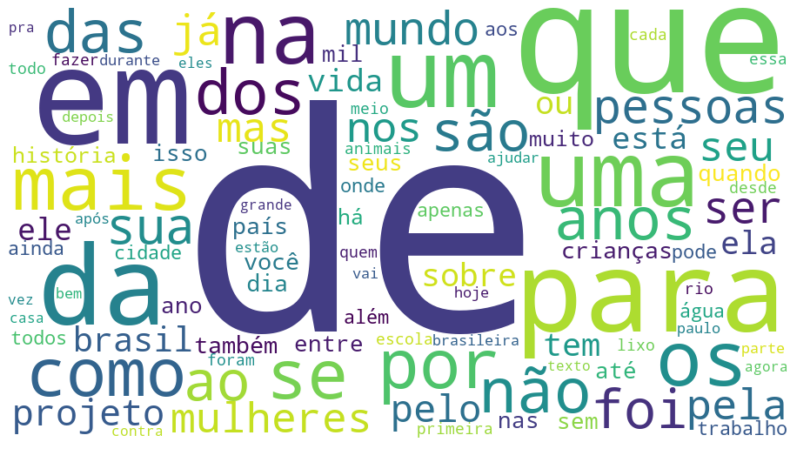

words  count    pos
0         ,   5313  PUNCT
1        de   4742    ADP
2         .   3214  PUNCT
3         a   3079    ADP
4         e   2675  CCONJ
..      ...    ...    ...
95  animais     90   NOUN
96     meio     89   NOUN
97    foram     88    AUX
98     quem     88   PRON
99     cada     87    DET

[100 rows x 3 columns]

In [10]:
plot_wordcloud(data['Title_and_Content'])
plot_term_scatter(data, 'Title_and_Content')

### 3.2 Balanceando o dataset

In [11]:
data['ID'] = data.index
df_categories3 = plot_categories_distribution(data, 
                                              'Label_Train', 
                                              'ID',
                                              'Distribution of categories after oversampling'
                                             )

In [12]:
categories_df = data['Label_Train'].value_counts().reset_index()
categories_mean = categories_df['Label_Train'].mean()
categories_std = categories_df['Label_Train'].std()
print("Mean number of samples of each category is: ", categories_mean)
print("Standard deviation number of samples of each category is: ", categories_std)

over_categories = [obs[0] for obs in categories_df.values if obs[1] > categories_mean+categories_std]
under_categories = [obs[0] for obs in categories_df.values if obs[1] < categories_mean-categories_std]
print("\nOverrepresented categories:", over_categories)
print("Underrepresented categories:", under_categories)
print("PS: The outliers were calculated using the 1 standart deviation")

Mean number of samples of each category is:  110.75
Standard deviation number of samples of each category is:  64.80277771824291

Overrepresented categories: ['ecologia', 'solidariedade']
Underrepresented categories: ['criancas', 'familia', 'idosos']
PS: The outliers were calculated using the 1 standart deviation


In [13]:
data.loc[data['Label_Train'].isin(under_categories), 'Label_Train'] = "others"

#for category in over_categories:
top_limit = categories_mean + categories_std
grouped_data_df = data[~data['Label_Train'].isin(over_categories)]
for over in over_categories:
    over_df = data[data['Label_Train'] == over].sample(int(top_limit))
    grouped_data_df = grouped_data_df.append(over_df)

In [14]:
grouped_data_df['ID'] = grouped_data_df.index
df_categories4 = plot_categories_distribution(grouped_data_df, 
                                              'Label_Train', 
                                              'ID',
                                              'Distribuition of categories after grouping and filtering'
                                             )

In [15]:
grouped_data_df.head()

Title_and_Content  Label_Train  ID
0  há mais de 10 anos, dupla de cães 🐶 acompanha ...      animais   0
2  20 fotos maravilhosas mostrando a alegria de t...       others   2
3  13 razões pelas quais crianças são bem mais es...       others   3
4  ex-executiva fala sobre vida sem propósito - i...    proposito   4
5  todos os casos registrados em 10 anos por dele...  diversidade   5

In [16]:
data = grouped_data_df.drop(['ID'], axis=1)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 167
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Title_and_Content  1678 non-null   object
 1   Label_Train        1678 non-null   object
dtypes: object(2)
memory usage: 39.3+ KB


### 3.3 Retirando pontos e vírgulas

In [18]:
data['Without_punctuations'] = data['Title_and_Content'].str.replace('[^\w\s]','')
data['Without_punctuations'] = data['Without_punctuations'].str.replace(r'\s+|\n',' ').str.strip()

In [19]:
data.head()

Title_and_Content  Label_Train  \
0  há mais de 10 anos, dupla de cães 🐶 acompanha ...      animais   
2  20 fotos maravilhosas mostrando a alegria de t...       others   
3  13 razões pelas quais crianças são bem mais es...       others   
4  ex-executiva fala sobre vida sem propósito - i...    proposito   
5  todos os casos registrados em 10 anos por dele...  diversidade   

                                Without_punctuations  
0  há mais de 10 anos dupla de cães acompanha cam...  
2  20 fotos maravilhosas mostrando a alegria de t...  
3  13 razões pelas quais crianças são bem mais es...  
4  exexecutiva fala sobre vida sem propósito ibc ...  
5  todos os casos registrados em 10 anos por dele...

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 167
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title_and_Content     1678 non-null   object
 1   Label_Train           1678 non-null   object
 2   Without_punctuations  1678 non-null   object
dtypes: object(3)
memory usage: 52.4+ KB


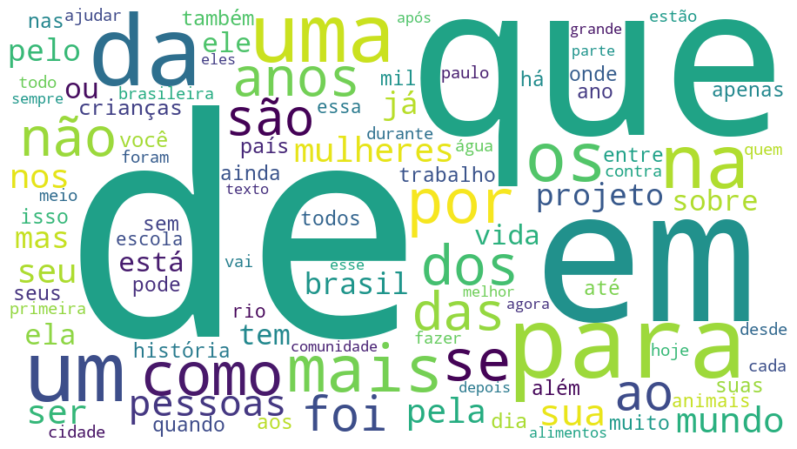

words  count    pos
0       de   4418    ADP
1        a   2891    ADP
2        e   2498  CCONJ
3        o   2259    DET
4      que   1854  SCONJ
..     ...    ...    ...
95  contra     72    ADP
96    água     72   NOUN
97    após     71  SCONJ
98  depois     71    ADV
99   parte     71   NOUN

[100 rows x 3 columns]

In [21]:
plot_wordcloud(data['Without_punctuations'])
plot_term_scatter(data, 'Without_punctuations')

### 3.4 Removendo Stopwords

In [22]:
nltk.download('stopwords')
stopwords_set = set(STOP_WORDS).union(set(stopwords.words('portuguese')))\
                               .union(set(['anos', 'ano', 'dia', 'dias']))
    
print("This is the stopword list: ", sorted(list(stopwords_set)))

This is the stopword list:  ['a', 'acerca', 'ademais', 'adeus', 'agora', 'ainda', 'algo', 'algumas', 'alguns', 'ali', 'além', 'ambas', 'ambos', 'ano', 'anos', 'antes', 'ao', 'aos', 'apenas', 'apoia', 'apoio', 'apontar', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'as', 'assim', 'através', 'atrás', 'até', 'aí', 'baixo', 'bastante', 'bem', 'boa', 'bom', 'breve', 'cada', 'caminho', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'com', 'como', 'comprida', 'comprido', 'conhecida', 'conhecido', 'conselho', 'contra', 'contudo', 'corrente', 'cuja', 'cujo', 'custa', 'cá', 'da', 'daquela', 'daquele', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'des', 'desde', 'dessa', 'desse', 'desta', 'deste', 'deve', 'devem', 'deverá', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'dias', 'direita', 'disso', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dá', 'dã

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/moutinho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
pattern = r'\b(?:{})\b'.format('|'.join(stopwords_set))
data['Without_stopwords'] = data['Without_punctuations'].str.replace(pattern, '')
data['Without_stopwords'] = data['Without_stopwords'].str.replace(r'\d+', '')
data['Without_stopwords'] = data['Without_stopwords'].str.replace(r'\s+|\n',' ').str.strip()

In [24]:
data.head()

Title_and_Content  Label_Train  \
0  há mais de 10 anos, dupla de cães 🐶 acompanha ...      animais   
2  20 fotos maravilhosas mostrando a alegria de t...       others   
3  13 razões pelas quais crianças são bem mais es...       others   
4  ex-executiva fala sobre vida sem propósito - i...    proposito   
5  todos os casos registrados em 10 anos por dele...  diversidade   

                                Without_punctuations  \
0  há mais de 10 anos dupla de cães acompanha cam...   
2  20 fotos maravilhosas mostrando a alegria de t...   
3  13 razões pelas quais crianças são bem mais es...   
4  exexecutiva fala sobre vida sem propósito ibc ...   
5  todos os casos registrados em 10 anos por dele...   

                                 Without_stopwords  
0  dupla cães acompanha caminhão coleta lixo paulo  
2      fotos maravilhosas mostrando alegria irmãos  
3                   razões crianças espertas gente  
4     exexecutiva fala vida propósito ibc coaching  
5      casos registrados delegacia especializada g

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 167
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title_and_Content     1678 non-null   object
 1   Label_Train           1678 non-null   object
 2   Without_punctuations  1678 non-null   object
 3   Without_stopwords     1678 non-null   object
dtypes: object(4)
memory usage: 65.5+ KB


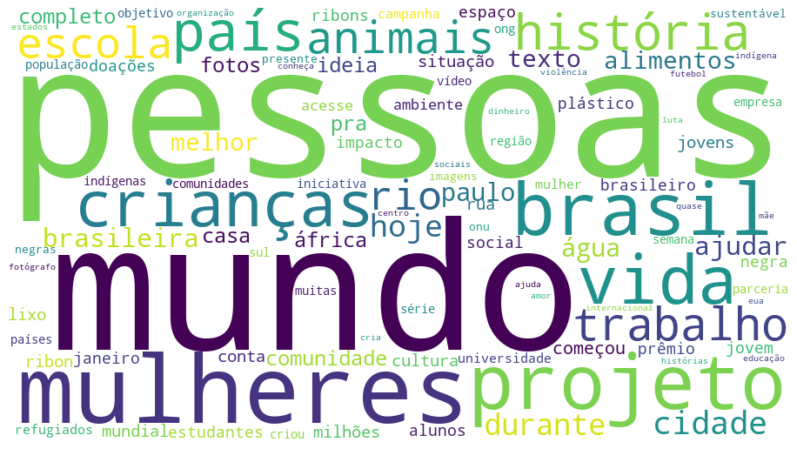

words  count    pos
0         pessoas    243   NOUN
1           mundo    217   NOUN
2        mulheres    200   NOUN
3         projeto    189   NOUN
4          brasil    172  PROPN
..            ...    ...    ...
95            eua     36  PROPN
96  internacional     35    ADJ
97        conheça     35   VERB
98        estados     35   NOUN
99          disse     34   VERB

[100 rows x 3 columns]

In [26]:
plot_wordcloud(data['Without_stopwords'])
plot_term_scatter(data, 'Without_stopwords')

### 3.5.1 Normalização: Stemming

In [27]:
def stem_words(text):    
    tokenizer = WordPunctTokenizer()
    stemmer = RSLPStemmer()
    words = tokenizer.tokenize(text)
    stemmed_words = map(lambda word : stemmer.stem(word), words)

    return ' '.join(stemmed_words)

In [28]:
nltk.download('rslp')
data['Data_stemmed'] = data['Without_stopwords'].apply(stem_words)

[nltk_data] Downloading package rslp to /home/moutinho/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [29]:
data.head()

Title_and_Content  Label_Train  \
0  há mais de 10 anos, dupla de cães 🐶 acompanha ...      animais   
2  20 fotos maravilhosas mostrando a alegria de t...       others   
3  13 razões pelas quais crianças são bem mais es...       others   
4  ex-executiva fala sobre vida sem propósito - i...    proposito   
5  todos os casos registrados em 10 anos por dele...  diversidade   

                                Without_punctuations  \
0  há mais de 10 anos dupla de cães acompanha cam...   
2  20 fotos maravilhosas mostrando a alegria de t...   
3  13 razões pelas quais crianças são bem mais es...   
4  exexecutiva fala sobre vida sem propósito ibc ...   
5  todos os casos registrados em 10 anos por dele...   

                                 Without_stopwords  \
0  dupla cães acompanha caminhão coleta lixo paulo   
2      fotos maravilhosas mostrando alegria irmãos   
3                   razões crianças espertas gente   
4     exexecutiva fala vida propósito ibc coaching   
5      casos registrados delegacia especializada g   

                              Data_stemmed  
0  dupl cão acompanh caminh colet lix paul  
2             fot maravilh mostr alegr irm  
3                    ra crianç espert gent  
4    exexecu fal vid propósit ibc coaching  
5             cas registr delegac especi g

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 167
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title_and_Content     1678 non-null   object
 1   Label_Train           1678 non-null   object
 2   Without_punctuations  1678 non-null   object
 3   Without_stopwords     1678 non-null   object
 4   Data_stemmed          1678 non-null   object
dtypes: object(5)
memory usage: 78.7+ KB


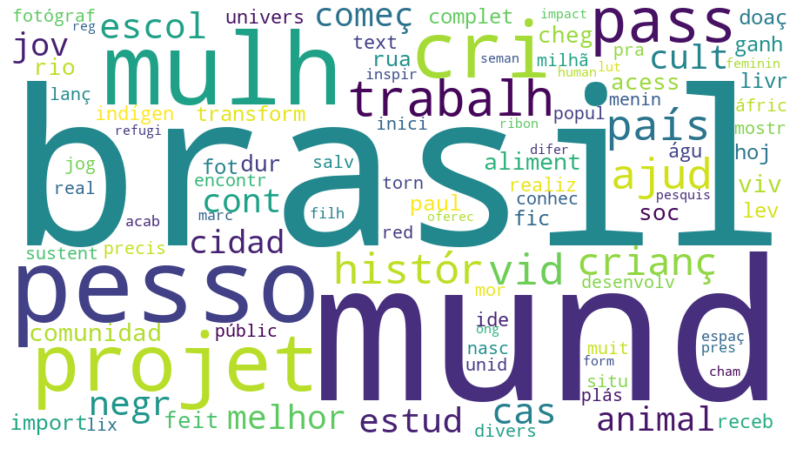

words  count    pos
0   brasil    345  PROPN
1     mund    279   NOUN
2    pesso    262    ADV
3     mulh    244  PROPN
4   projet    223  PROPN
..     ...    ...    ...
95    form     58  PROPN
96   ribon     57   NOUN
97    cham     57   VERB
98     reg     57   INTJ
99   difer     57   NOUN

[100 rows x 3 columns]

In [31]:
plot_wordcloud(data['Data_stemmed'])
plot_term_scatter(data, 'Data_stemmed')

### 3.5.1 Normalização:  Lemmatização

In [32]:
def lem_words(text):
    
    doc = NLP_SPACY(text)
    lemmatized_doc = " ".join([word.lemma_ for word in doc])
    
    return lemmatized_doc

In [33]:
data['Data_lemmatized'] = data['Without_stopwords'].apply(lem_words)

In [34]:
data.head()

Title_and_Content  Label_Train  \
0  há mais de 10 anos, dupla de cães 🐶 acompanha ...      animais   
2  20 fotos maravilhosas mostrando a alegria de t...       others   
3  13 razões pelas quais crianças são bem mais es...       others   
4  ex-executiva fala sobre vida sem propósito - i...    proposito   
5  todos os casos registrados em 10 anos por dele...  diversidade   

                                Without_punctuations  \
0  há mais de 10 anos dupla de cães acompanha cam...   
2  20 fotos maravilhosas mostrando a alegria de t...   
3  13 razões pelas quais crianças são bem mais es...   
4  exexecutiva fala sobre vida sem propósito ibc ...   
5  todos os casos registrados em 10 anos por dele...   

                                 Without_stopwords  \
0  dupla cães acompanha caminhão coleta lixo paulo   
2      fotos maravilhosas mostrando alegria irmãos   
3                   razões crianças espertas gente   
4     exexecutiva fala vida propósito ibc coaching   
5      casos registrados delegacia especializada g   

                              Data_stemmed  \
0  dupl cão acompanh caminh colet lix paul   
2             fot maravilh mostr alegr irm   
3                    ra crianç espert gent   
4    exexecu fal vid propósit ibc coaching   
5             cas registr delegac especi g   

                                    Data_lemmatized  
0  duplo cão acompanhar caminhão coleta lixar paulo  
2            foto maravilhoso mostrar alegria irmão  
3                       razão criança esperto gente  
4    exexecutiva falir vidar propósito ibc coaching  
5           caso registrar delegacia especializar g

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 167
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Title_and_Content     1678 non-null   object
 1   Label_Train           1678 non-null   object
 2   Without_punctuations  1678 non-null   object
 3   Without_stopwords     1678 non-null   object
 4   Data_stemmed          1678 non-null   object
 5   Data_lemmatized       1678 non-null   object
dtypes: object(6)
memory usage: 91.8+ KB


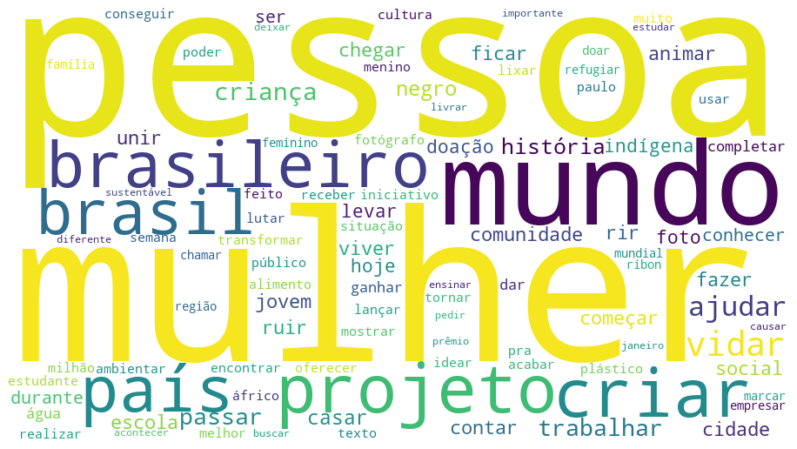

words  count    pos
0        pessoa    262   NOUN
1        mulher    244   NOUN
2         mundo    217   NOUN
3       projeto    189   NOUN
4         criar    186   VERB
..          ...    ...    ...
95       prêmio     53  PROPN
96       buscar     53   VERB
97    diferente     53    ADJ
98      janeiro     53   NOUN
99  sustentável     53    ADJ

[100 rows x 3 columns]

In [36]:
plot_wordcloud(data['Data_lemmatized'])
plot_term_scatter(data, 'Data_lemmatized')

### 3.6 Filtro de entidades 

In [37]:
def entitiesRecog(lemmatized_data):
    entities_obs = []
    for doc in lemmatized_data:
        doc = NLP_SPACY(doc)
        for token in doc:
            if token.ent_type_:
                entities_obs.append((token.text, token.ent_type_))

    entities_df = pd.DataFrame(entities_obs, columns=['entity_text', 'entity_type'])
    entities_df['id'] = entities_df.index
    grouped_entities_df = (entities_df.groupby(['entity_text', 'entity_type']).count()
                                                                             .reset_index()
                                                                             .rename(columns={'id': 'count'})
                                                                             .sort_values('count', ascending=False)
                                                                             .head(100))

    fig = px.treemap(grouped_entities_df, 
                     path=['entity_type', 'entity_text'], 
                     values='count', 
                     title='Top-50 entities present in text grouped by type')
    fig.show()
    entity_type_df = grouped_entities_df['entity_type'].value_counts().reset_index()

    fig = px.pie(entity_type_df, values='entity_type', names='index', title='Entity type frequency')
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.show()

In [38]:
entitiesRecog(data['Data_lemmatized'])

In [39]:
def exclude_unwanted_entity(lemmatized_data):
    processed_tokenized_data = []
    processed_doc_text = []
    entity_unwanted_types = set(['PER', 'ORG'])

    for doc in lemmatized_data:
        doc = NLP_SPACY(doc)
        entities_text = ""
        processed_doc = []
        for token in doc:
            if not token.ent_type_:
                processed_doc.append(token)
            elif not token.ent_type_ in entity_unwanted_types:
                processed_doc.append(token)

        processed_doc_text.append(" ".join([word.norm_ for word in processed_doc ]))
    return processed_doc_text

In [40]:
data['Data_without_entities'] = exclude_unwanted_entity(data['Data_lemmatized'])

In [41]:
data.head()

Title_and_Content  Label_Train  \
0  há mais de 10 anos, dupla de cães 🐶 acompanha ...      animais   
2  20 fotos maravilhosas mostrando a alegria de t...       others   
3  13 razões pelas quais crianças são bem mais es...       others   
4  ex-executiva fala sobre vida sem propósito - i...    proposito   
5  todos os casos registrados em 10 anos por dele...  diversidade   

                                Without_punctuations  \
0  há mais de 10 anos dupla de cães acompanha cam...   
2  20 fotos maravilhosas mostrando a alegria de t...   
3  13 razões pelas quais crianças são bem mais es...   
4  exexecutiva fala sobre vida sem propósito ibc ...   
5  todos os casos registrados em 10 anos por dele...   

                                 Without_stopwords  \
0  dupla cães acompanha caminhão coleta lixo paulo   
2      fotos maravilhosas mostrando alegria irmãos   
3                   razões crianças espertas gente   
4     exexecutiva fala vida propósito ibc coaching   
5      casos registrados delegacia especializada g   

                              Data_stemmed  \
0  dupl cão acompanh caminh colet lix paul   
2             fot maravilh mostr alegr irm   
3                    ra crianç espert gent   
4    exexecu fal vid propósit ibc coaching   
5             cas registr delegac especi g   

                                    Data_lemmatized  \
0  duplo cão acompanhar caminhão coleta lixar paulo   
2            foto maravilhoso mostrar alegria irmão   
3                       razão criança esperto gente   
4    exexecutiva falir vidar propósito ibc coaching   
5           caso registrar delegacia especializar g   

                              Data_without_entities  
0  duplo cão acompanhar caminhão coleta lixar paulo  
2            foto maravilhoso mostrar alegria irmão  
3                       razão criança esperto gente  
4    exexecutiva falir vidar propósito ibc coaching  
5           caso registrar delegacia especializar g

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 167
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title_and_Content      1678 non-null   object
 1   Label_Train            1678 non-null   object
 2   Without_punctuations   1678 non-null   object
 3   Without_stopwords      1678 non-null   object
 4   Data_stemmed           1678 non-null   object
 5   Data_lemmatized        1678 non-null   object
 6   Data_without_entities  1678 non-null   object
dtypes: object(7)
memory usage: 104.9+ KB


In [43]:
entitiesRecog(data['Data_without_entities'])

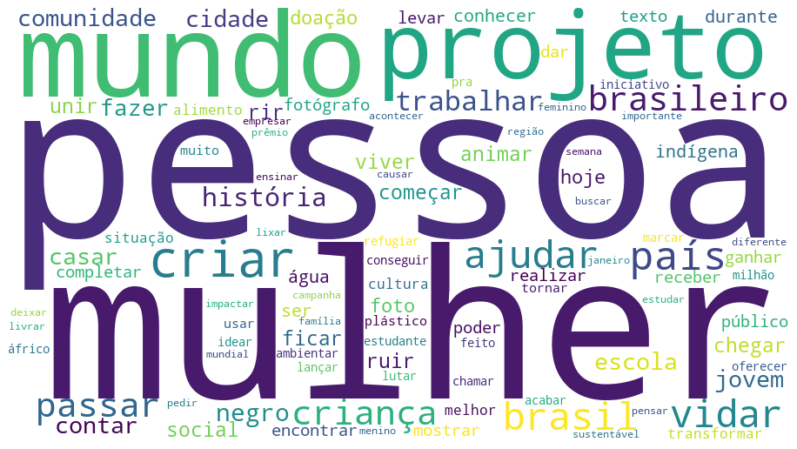

words  count    pos
0     pessoa    244   NOUN
1     mulher    243   NOUN
2      mundo    216   NOUN
3    projeto    189   NOUN
4      criar    185   VERB
..       ...    ...    ...
95   janeiro     52   NOUN
96    prêmio     52  PROPN
97  campanha     52   NOUN
98  impactar     52   VERB
99    pensar     52   VERB

[100 rows x 3 columns]

In [44]:
plot_wordcloud(data['Data_without_entities'])
plot_term_scatter(data, 'Data_without_entities')

### 3.7 Filtro de POS (Parts of Speech) AKA Classes Gramaticais

In [45]:
def posRecog(lemmatized_data):
    token_obs = []
    for doc in lemmatized_data:
        doc = NLP_SPACY(doc)
        for token in doc:
            token_obs.append((token.norm_, token.pos_))

    token_df = pd.DataFrame(token_obs)
    token_df.columns = ['token', 'pos']
    token_df['id'] = token_df.index

    ''' Plotting token grouped by POS treemap '''
    grouped_token_df = (token_df.groupby(['token', 'pos']).count()
                                                         .reset_index()
                                                         .rename(columns={'id': 'count'})
                                                         .sort_values('count', ascending=False)
                                                         .head(100))

    fig = px.treemap(grouped_token_df, 
                     path=['pos', 'token'], 
                     values='count', 
                     title='Top-100 tokens present in text grouped by Part-of-Speech')
    fig.show()

    ''' Plotting POS bar chart '''
    pos_df = token_df.groupby('pos').count().reset_index().rename(columns={'token':'count'})

    fig = px.bar(pos_df, x='pos', y='count', text='count', title="Part-of-Speech type frequency")
    fig.update_layout(xaxis_categoryorder = 'total descending')
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.show()

In [46]:
posRecog(data['Data_without_entities'])

In [47]:
def exclude_pos(lemmatized_data):
    
    allowed_pos_set = set(["PROPN", "NOUN", "ADV", "ADJ", "VERB"])

    processed_doc = []
    for doc in lemmatized_data:
        doc = NLP_SPACY(doc)
        doc_tokens = [word for word in doc if str(word.pos_) in allowed_pos_set]
        processed_doc.append(" ".join(token.norm_ for token in doc_tokens))
    
    return processed_doc

In [48]:
data['Data_without_pos'] = exclude_pos(data['Data_lemmatized'])

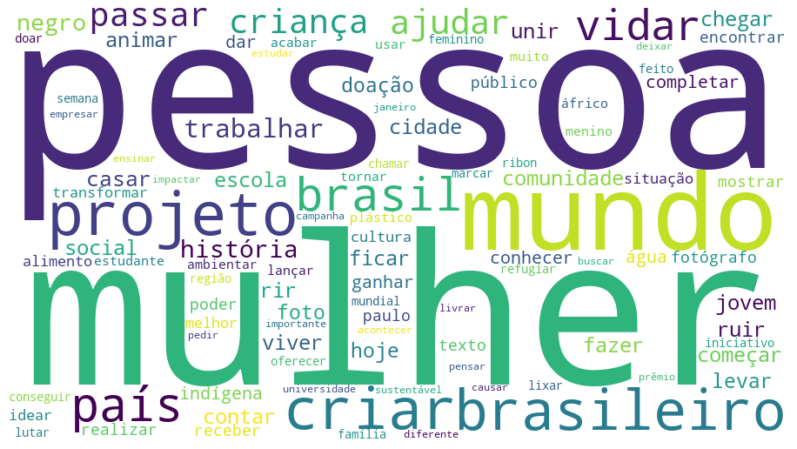

words  count   pos
0         pessoa    262  NOUN
1         mulher    244  NOUN
2          mundo    217  NOUN
3        projeto    189  NOUN
4          criar    186  VERB
..           ...    ...   ...
95       janeiro     53  NOUN
96  universidade     52  NOUN
97        pensar     52  VERB
98      campanha     52  NOUN
99      impactar     52  VERB

[100 rows x 3 columns]

In [49]:
plot_wordcloud(data['Data_without_pos'])
plot_term_scatter(data, 'Data_without_pos')

In [50]:
posRecog(data['Data_without_pos'])

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 167
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Title_and_Content      1678 non-null   object
 1   Label_Train            1678 non-null   object
 2   Without_punctuations   1678 non-null   object
 3   Without_stopwords      1678 non-null   object
 4   Data_stemmed           1678 non-null   object
 5   Data_lemmatized        1678 non-null   object
 6   Data_without_entities  1678 non-null   object
 7   Data_without_pos       1678 non-null   object
dtypes: object(8)
memory usage: 118.0+ KB


In [52]:
data.head()

Title_and_Content  Label_Train  \
0  há mais de 10 anos, dupla de cães 🐶 acompanha ...      animais   
2  20 fotos maravilhosas mostrando a alegria de t...       others   
3  13 razões pelas quais crianças são bem mais es...       others   
4  ex-executiva fala sobre vida sem propósito - i...    proposito   
5  todos os casos registrados em 10 anos por dele...  diversidade   

                                Without_punctuations  \
0  há mais de 10 anos dupla de cães acompanha cam...   
2  20 fotos maravilhosas mostrando a alegria de t...   
3  13 razões pelas quais crianças são bem mais es...   
4  exexecutiva fala sobre vida sem propósito ibc ...   
5  todos os casos registrados em 10 anos por dele...   

                                 Without_stopwords  \
0  dupla cães acompanha caminhão coleta lixo paulo   
2      fotos maravilhosas mostrando alegria irmãos   
3                   razões crianças espertas gente   
4     exexecutiva fala vida propósito ibc coaching   
5      casos registrados delegacia especializada g   

                              Data_stemmed  \
0  dupl cão acompanh caminh colet lix paul   
2             fot maravilh mostr alegr irm   
3                    ra crianç espert gent   
4    exexecu fal vid propósit ibc coaching   
5             cas registr delegac especi g   

                                    Data_lemmatized  \
0  duplo cão acompanhar caminhão coleta lixar paulo   
2            foto maravilhoso mostrar alegria irmão   
3                       razão criança esperto gente   
4    exexecutiva falir vidar propósito ibc coaching   
5           caso registrar delegacia especializar g   

                              Data_without_entities  \
0  duplo cão acompanhar caminhão coleta lixar paulo   
2            foto maravilhoso mostrar alegria irmão   
3                       razão criança esperto gente   
4    exexecutiva falir vidar propósito ibc coaching   
5           caso registrar delegacia especializar g   

                                   Data_without_pos  
0  duplo cão acompanhar caminhão coleta lixar paulo  
2            foto maravilhoso mostrar alegria irmão  
3                       razão criança esperto gente  
4    exexecutiva falir vidar propósito ibc coaching  
5                registrar delegacia especializar g

## 4. Comparando acurácias para cada filtro

In [53]:
def get_mean_accuracies(data, model, ngram_range, columns_to_compare):
    mean_accuracies = np.array([])
    y = data['Label_Train']

    for column in columns_to_compare:
        X = data[column]
        tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range=ngram_range, use_idf=True)

        tfidf_pipeline = Pipeline([
            ('vectorizing', tfidf_vectorizer),
            ('classifier', model)
        ])
        
        tfidf_results = cross_validate(tfidf_pipeline, X, y, cv=StratifiedKFold(shuffle=True))

        mean_accuracies = np.append(mean_accuracies, tfidf_results['test_score'].mean())
        
    return mean_accuracies

In [54]:
COLUMNS_TO_COMPARE = [
'Title_and_Content',
'Without_punctuations',
'Without_stopwords',
'Data_stemmed',
'Data_lemmatized',
'Data_without_entities',
'Data_without_pos']
model = SGDClassifier()
mean_accuracies = get_mean_accuracies(data=data,
                                    model=model, 
                                    columns_to_compare=COLUMNS_TO_COMPARE, 
                                    ngram_range=(1,3))

In [55]:
comparison = pd.Series(mean_accuracies*100, index=COLUMNS_TO_COMPARE)
comparison

Title_and_Content        66.748756
Without_punctuations     65.316453
Without_stopwords        68.891791
Data_stemmed             70.145878
Data_lemmatized          71.693141
Data_without_entities    67.163824
Data_without_pos         70.203980
dtype: float64

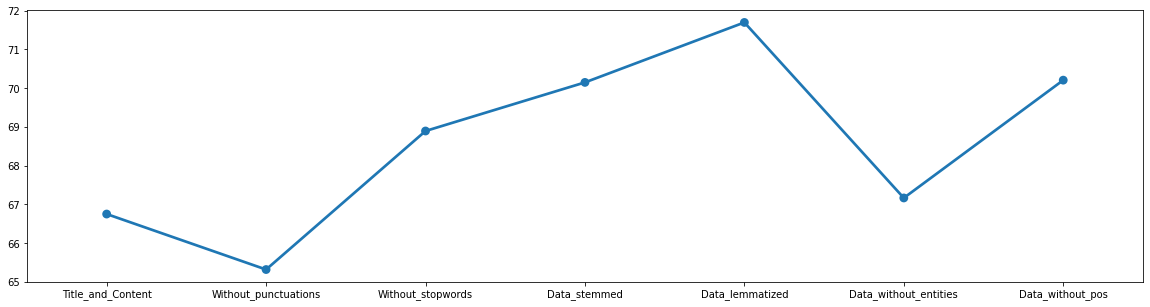

In [56]:
ax = sns.pointplot(x=comparison.index, y=comparison.values)
ax.figure.set_size_inches(20, 5)

## 5. Analisando Modelo

### 5.1 Text parser and model training

In [57]:
''' Let's evaluate more deeply the best model '''
X_train, X_test, y_train, y_test = train_test_split(
    data['Data_without_pos'].to_list(),
    data['Label_Train'].to_list(),
    test_size=0.25, random_state=42)

tfidf_vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,3), use_idf=True)

pipeline = Pipeline([
    ('vectorizing', tfidf_vectorizer),
    ('classifier', model)
])

train1 = X_train
labelsTrain1 = y_train
test1 = X_test
labelsTest1 = y_test
"""  train """
pipeline.fit(train1, labelsTrain1)
"""  test """
preds = pipeline.predict(test1)
print("accuracy:", accuracy_score(labelsTest1, preds))
print(
    classification_report(
        labelsTest1,
        preds))

accuracy: 0.6952380952380952
                  precision    recall  f1-score   support

         animais       0.79      0.81      0.80        27
      celebracao       0.55      0.52      0.54        21
         ciencia       0.89      0.73      0.80        11
         cultura       0.70      0.76      0.73        46
     diversidade       0.73      0.53      0.62        45
        ecologia       0.79      0.79      0.79        39
        educacao       0.68      0.74      0.71        38
empreendedorismo       0.67      0.67      0.67        18
         esporte       0.81      0.77      0.79        22
          etnias       0.73      0.71      0.72        38
          others       0.56      0.65      0.60        23
       proposito       0.70      0.60      0.65        43
           saude       0.80      0.33      0.47        12
   solidariedade       0.58      0.86      0.70        37

        accuracy                           0.70       420
       macro avg       0.71      0.68    

### 5.2 Confusion Matrix

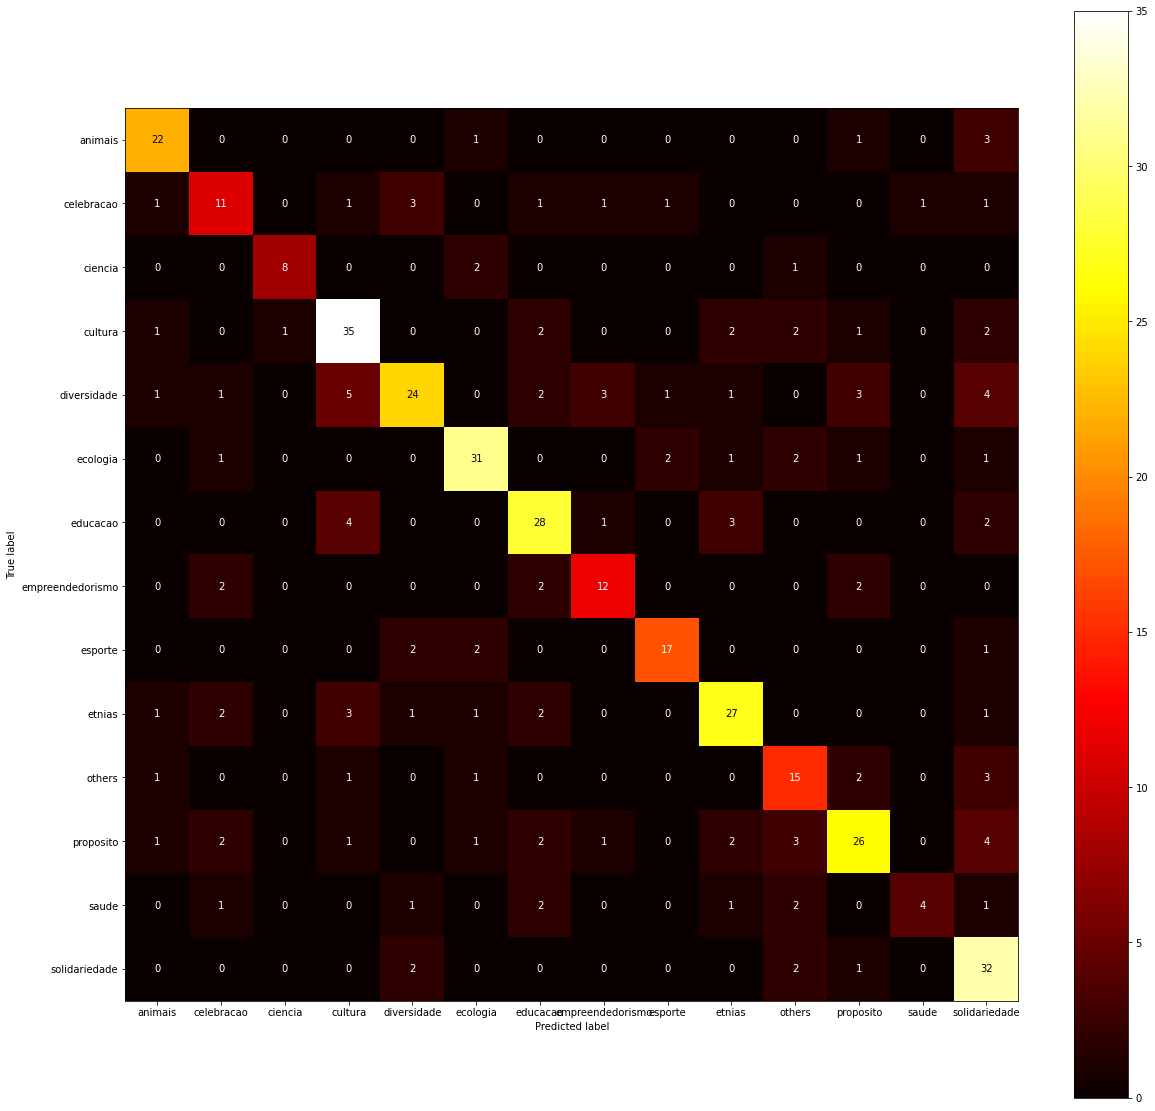

In [59]:
fig = plt.figure(figsize=(20, 20))
axes = plt.axes()

plot_confusion_matrix(pipeline, test1, labelsTest1, cmap='hot', ax=axes)